In [131]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import OneHotEncoder
import xgboost
from catboost import CatBoostClassifier, Pool # cat_features parametr !

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as smon
from scipy import stats

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

In [132]:
df = pd.read_csv("air_temperature_lstm_data.csv").iloc[40000:]
ef = pd.read_csv("co2_lstm_data.csv").iloc[40000:]

to_time = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [133]:
ef["datetime"] = ef["datetime"].apply(to_time)
df["datetime"] = df["datetime"].apply(to_time)

In [134]:
df.index = df["datetime"]
ef.index = ef["datetime"]
df = df.drop(["datetime"], axis = 1)
ef = ef.drop(["datetime"], axis = 1)

In [135]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
df = scaler1.fit_transform(df)
ef = scaler2.fit_transform(ef)

In [136]:
import tensorflow
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

In [137]:
seq_len = 10

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(df, seq_len, train_frac=0.99)

In [138]:
dropout = 0.2
window_size = seq_len - 1

model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM((window_size), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
model.add(Activation('linear'))

C:\Users\Gjallar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [139]:
batch_size = 8
adam = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss='mean_squared_error',
    optimizer=adam
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.01
)

Epoch 1/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 98s 15ms/step - loss: 0.3740 - val_loss: 0.0864
Epoch 2/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 0.0854 - val_loss: 0.0780
Epoch 3/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - loss: 0.0783 - val_loss: 0.0756
Epoch 4/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - loss: 0.0752 - val_loss: 0.0727
Epoch 5/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - loss: 0.0710 - val_loss: 0.0689
Epoch 6/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - loss: 0.0681 - val_loss: 0.0643
Epoch 7/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 0.0653 - val_loss: 0.0607
Epoch 8/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - loss: 0.0632 - val_loss: 0.0589
Epoch 9/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - loss: 0.0593 - val_loss: 0.0565
Epoch 10/10
6010/6010 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 0.0551 - val_loss: 0.0505


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


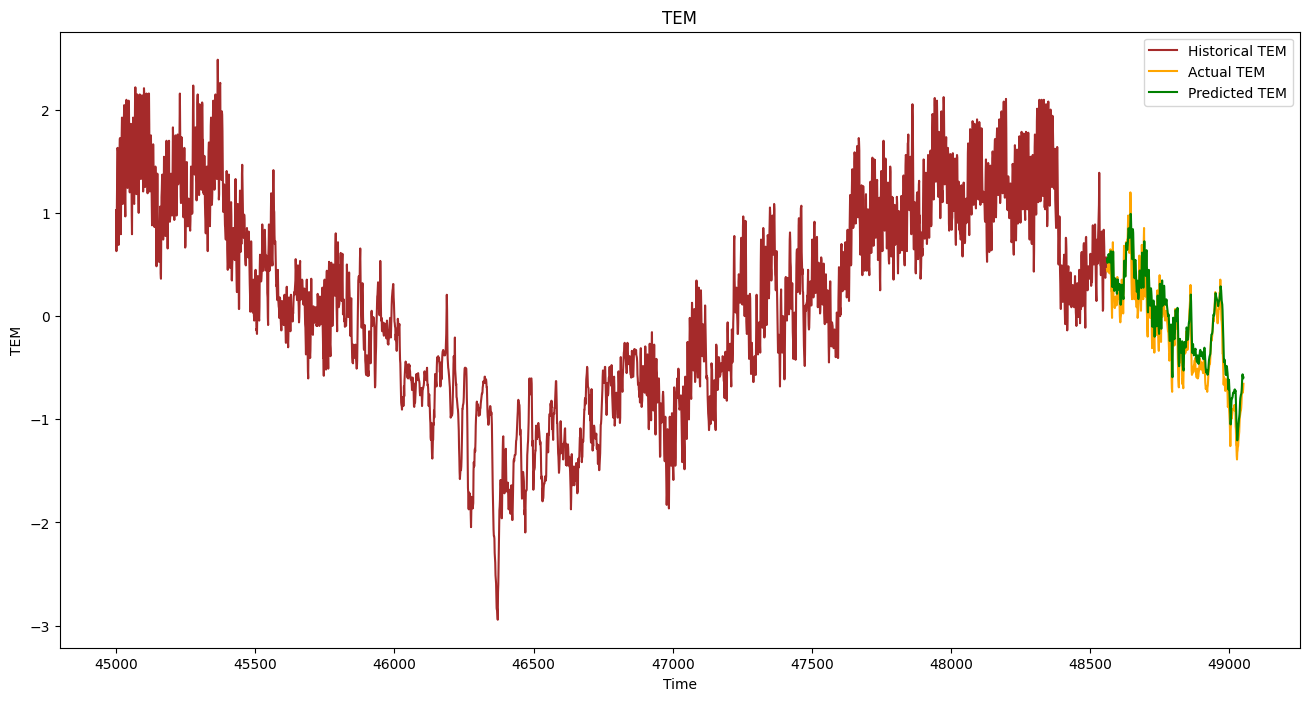

In [143]:
y_pred = model.predict(x_test)
sl = 45000

plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(y_train))[sl:], y_train[sl:], color='brown', label='Historical TEM')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, color='orange', label='Actual TEM')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred)), y_pred, color='green', label='Predicted TEM')

plt.title('TEM')
plt.xlabel('Time')
plt.ylabel('TEM')
plt.legend()
plt.show()